# NLP on PRR: Visualization and Interaction

## Overview of the Jupyter Environment
Jupyter notebooks are interactive environments that allow you to play with and execute code in the browser. They can enable you to perform exploratory analyses and visualize datasets easily and rapidly. This notebook is running on a platform called Binder, which you can learn more about at https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook.

If you don't want (or unable) to run this notebook in the browser, you can download the Anaconda scientific computing distribution at https://anaconda.org and learn how to use it at https://www.datacamp.com/learn-python-with-anaconda.

**Warning:** While installing Anaconda is straightforward most of the time, you might occasionally run into trouble if you have limited experience installing libraries or setting up development environments. Don't be afraid to ask for help on Stack Overflow, or from your friendly neighborhood IT department. Be sure to install all of the required Python packages using the `requirements.txt` file associated with the notebook.

## Browsers 
If you want to use the visualization notebook effectively, be sure to use it on *Firefox* or *Google Chrome*. If you're on macOS, *Safari* works okay, but browsers like *Internet Explorer* or *Edge* do not work well and **should be avoided**.

## Quickstart
If you have never worked with this environment before, please do the following:

1. On the **Header Menu**, navigate to **Cell** and choose *Run All*. This gets everything ready for interaction/use.
2. If you make a change in any of the cells, be sure to *run* it for the changes to take effect. If you see `[*]` on the left side of a cell, the contents of the cell are currently running. It is best to wait until the process is complete before trying to make changes to other cells.

## Jump to a Visualization
1. [Word Cloud(s)](#Word-Cloud(s))
2. [Topics Over Time](#Topics-Over-Time)
3. [Cosine Word Similarity](#Cosine-Word-Similarity)
4. [Analogy Generator](#Analogy-Generator)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec, ldamodel
from IPython.core.display import display, HTML
from wordcloud import WordCloud
from bokeh.palettes import Category10
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, LassoSelectTool, ResetTool, BoxZoomTool
from bokeh.io import output_notebook
output_notebook()

# ignore numpy warnings for the older version
np.warnings.filterwarnings('ignore')

Loading BokehJS ...

In [17]:
# load the wordcloud words
wordcloud_words = pd.read_csv('data/wordcloud-master-data.csv')

# load the topic modeling datasets
topics = pd.read_csv('data/topics-over-time-data.csv',
                     index_col=['Unnamed: 0']).sort_index()

words_over_time = pd.read_csv('data/words-over-time.csv.bz2',
                     index_col=['create_date']).sort_index().drop(['Unnamed: 0'], axis=1)

# load the 2d word vector coords
coords = pd.read_json('data/word-coords-data.json')

# this is for loading the pre-saved word vectors
prr2vec = Word2Vec.load("trained/prr2vec.w2v")
ent2vec = Word2Vec.load("trained/ent2vec.w2v")

#### CODE TO TOGGLE CELL ON/OFF 
HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

This cell contains code to load the <strong>datasets</strong>.
To toggle this cell's visibility, click <a href="javascript:code_toggle()">here</a>.''')

In [18]:
#### CODE RELATED TO WORD CLOUD GENERATION

def sort(df, ls=[], ocfilter=5):
    # ARGUMENTS: df; a dataframe
    # ls; a list of filters
    # ocfilter; removes occurrences less than default
    # OUTPUTS: newdf; a sorted dataframe
    #
    # if the filter has nothing in it
    # then get counts for the whole dataframe
    if len(ls) == 0 :
        data = df
    # otherwise
    else:
        # make a new 
        data = pd.DataFrame()
        # for each item in the filter list
        for d in ls:
            # subset the dataframe
            mask = df[df['dept'] == d]
            # add the data to a new dataframe
            data = data.append(mask)
    # groupby word column and sum
    newdf = data.groupby('word').sum()
    # filter to remove words with low occurrence
    newdf = data[data['count'] > ocfilter]
    # return sorted df with word sums
    return newdf.sort_values(by='count', ascending=False)

def showcloud(wc_data, FILTER=[], save=False):
    # ARGUMENTS: wc_data; data source, list of words + freqs
    # FILTER; a list of stopwords, empty by default
    # save; boolean, False by default
    #
    # OUTPUTS: a plot; returns nothing
    #
    # uses the wordcloud library; if you know what you
    # are doing, feel free to change these parameters
    data = wc_data.reset_index()
    wordcloud = WordCloud(background_color='white',
                          width=1024,
                          stopwords=FILTER,
                          height=768,
                          max_words=50,
                          max_font_size=128,
                          random_state=42
                         ).generate(str(data['word']))

    # sets the canvas size for the plot
    plt.figure( figsize=(20,10) )
    # ...with no axes because that just looks weird
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.tight_layout(pad=0)
    plt.show()
    # shows the plot
    
##### PLOTTING TOPICS OVER TIME

def filter_dfs(df, string):
    cols = [i for i in df.columns if not i.find(string) ]
    return [ df[i] for i in cols ], cols

def count_keywords(df, col, topic):
    # ARGUMENTS: df; a dataframe
    # col; a column of the dataframe
    # topic; a list of lists, containing strings
    # OUTPUTS: data; a dataframe
    #
    # this function counts the mentions of a word
    #
    # generate an empty dataframe
    data = pd.DataFrame()
    # for each list of strings
    for i in topic:
        # subset the dataframe, and determine whether
        # a string is in a row. if it is, then return
        # True, otherwise false
        mask = df[col].str.contains(i)
        # subset the dataframe by values > 0 (i.e. True values)
        mask = mask[mask > 0]
        # reset the index and drop the indicies that are duplicates
        #
        # this ensures entries aren’t double-counted if they contain multiple words
        # related to a topic. it only gets the first entry in the topic category
        mask = mask.reset_index().drop_duplicates(subset='create_date', keep='first')
        # add the data to the dataframe
        data = data.append(mask)
    data = data.groupby('create_date').count().reset_index()
    data['create_date'] = data['create_date'].astype(str).str[0:7]
    data = data.groupby('create_date').sum()
    return data.sort_index()

def line(list_of_dfs):
    # ARGUMENTS: list_of_dfs; a list of dataframes
    # OUTPUTS: a plot
    #
    # this function counts the mentions of a word
    #
    # generate an empty dataframe
    # if you know what you are doing, don't be afraid to change the
    # parameters for size etc.
    p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")
    p.title.text = 'Click on legend entries to hide the corresponding lines'

    # the last item in the zipped tuple refers to the color
    # you can change this using bokeh's color palletes in the import
    # section above
    for data, name, color in zip(list_of_dfs[0], list_of_dfs[1], Category10[8]):
        df = pd.DataFrame(data)
        df = df.reset_index()
        df['index'] = pd.to_datetime(df['index'])
        p.line(df['index'], df[name], 
               line_width=2, color=color, alpha=0.8, legend=name)

    p.legend.location = "top_left"
    p.legend.click_policy="hide"

    show(p)
    
def scatter(df):
    # ARGUMENTS: df; a dataframe
    # OUTPUTS: a plot
    #
    # this function counts the mentions of a word
    #
    # generate an empty dataframe
    # if you know what you are doing, don't be afraid to change the
    # parameters for size etc.
    assert 'x' and 'y' and 'word' in df.columns

    hover = HoverTool(
            tooltips=[
                ("word", "@word"),
            ]
        )

    p = figure(plot_width=800, plot_height=800, tools=[hover],
               title="Mouse over the dots")
    
    p.add_tools(BoxZoomTool())
    p.add_tools(ResetTool())

    p.circle('x', 'y', size=5, source=df)
    show(p)
    
    
def make_user_plots():
    # we'll run each topic from above through a function and build a dataframe
    user_topics_dfs = [count_keywords(words_over_time, 'word', i) for i in user_topics]
    # combine the dataframes
    utdf = pd.concat(user_topics_dfs, axis=1, sort=True)
    # rename the columns
    utdf.columns = ["UT: "+ ' & '.join(i for i in j) for j in user_topics]
    # filter the dataframes
    user_choice = filter_dfs(utdf, 'UT:')
    # actually plot the data
    line(user_choice)

    
    
#### ANALOGY GENERATING

def word_analogy(word0='A', word2='Y', word3='Z'):
    # ARGUMENTS: word0, word2, word3; words in the corpus
    # if the defaults are kept, then B is a default too
    if word0 == 'A' or word2=='Y' or word3=='Z':
        calc = 'B'
    #
    # otherwise compute cosine similarity
    # it helps to think of it like this
    # "King" - "Man" + "Queen" == "Woman"
    #print(w2v_model.wv.most_similar(positive=['woman', 'king'], negative=['man']))
    else:
        calc = prr2vec.wv.most_similar(positive=[word0, word2],
                negative=[word3], topn=1)
    # and return some pretty printing
    return "{0} is to {1} as {2} is to {3}.".format(word0, calc[0][0], word2, word3)

def ent_analogy(word0='A', word2='Y', word3='Z'):
    # ARGUMENTS: word0, word2, word3; words in the corpus
    # if the defaults are kept, then B is a default too
    if word0 == 'A' or word2=='Y' or word3=='Z':
        calc = 'B'
    #
    # otherwise compute cosine similarity
    # it helps to think of it like this
    # "King" - "Man" + "Queen" == "Woman"
    #print(w2v_model.wv.most_similar(positive=['woman', 'king'], negative=['man']))
    else:
        calc = ent2vec.wv.most_similar(positive=[word0, word2],
                negative=[word3], topn=1)
    # and return some pretty printing
    return "{0} is to {1} as {2} is to {3}.".format(word0, calc[0][0], word2, word3)


def show_analogies():
    # OUTPUT: returns a list of analogies
    # as specified by the list of lists
    # above
    analogies = [
    ['surveillance', 'audio', 'video'], 
    ['dashcam', 'underground', 'tanks'],
    ['tank', 'request', 'record'],
    ['permit', 'parcel', 'zoning'],
    ['port', 'olympia', 'seattle'],
    ['state', 'county', 'thurston'],
    ['A', 'Y', 'Z']]
    
    return [word_analogy(i[0], i[1], i[2]) for i in analogies]

    
#### CODE TO TOGGLE CELL ON/OFF 
HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

This cell contains <strong>functions</strong> that abstract away complexity for better user interaction.
To toggle this cell's visibility, click <a href="javascript:code_toggle()">here</a>.''')

# Word Cloud(s)

In case you're unfamiliar, a word cloud is a visualization of the frequency of words appearing in a document. Words that are larger within the visualization occur more frequently.

By default, the word cloud below shows the frequency of words across the entire dataset. If you wish to see the words associated with a department (or series of departments), add your preferred 3-letter abbreviation/string to the list in the `sort()` function.

In [19]:
# this line prints out all of the department names
print(list(wordcloud_words['dept'].value_counts().index))

# choose the departments of interest in the brackets below
# right now we're just looking at seattle police and fire
wc_gen = sort(wordcloud_words, ['SPD', 'SFD'])

['SPD', 'Olympia Police Department', 'FAS', 'DOT', 'SCI', 'SFD', 'LEG', 'Community Planning and Development', 'LAW', 'SCL', 'MOS', 'Multiple Departments', 'PKS', 'SPU', 'SHR', "City Clerk's Office", 'OCR', 'HSD', 'Public Works', 'Administrative Services', 'PCD', 'ITD', 'EEC', 'CEN', 'Human Resources', 'DON', 'Fire', 'RET', 'OFH', 'OED', 'OLS', 'CBO', 'Executive', 'Community Development', 'DOE', 'Legal', 'OIR', 'OSE', 'ART', 'SPL', 'Public Works Department', 'HXM', 'Parks', 'CPC', 'SMC', 'IMR', 'CIV', 'PPN', 'ZZZ', 'Finance Department', 'Municipal Court', 'Site Administrator']


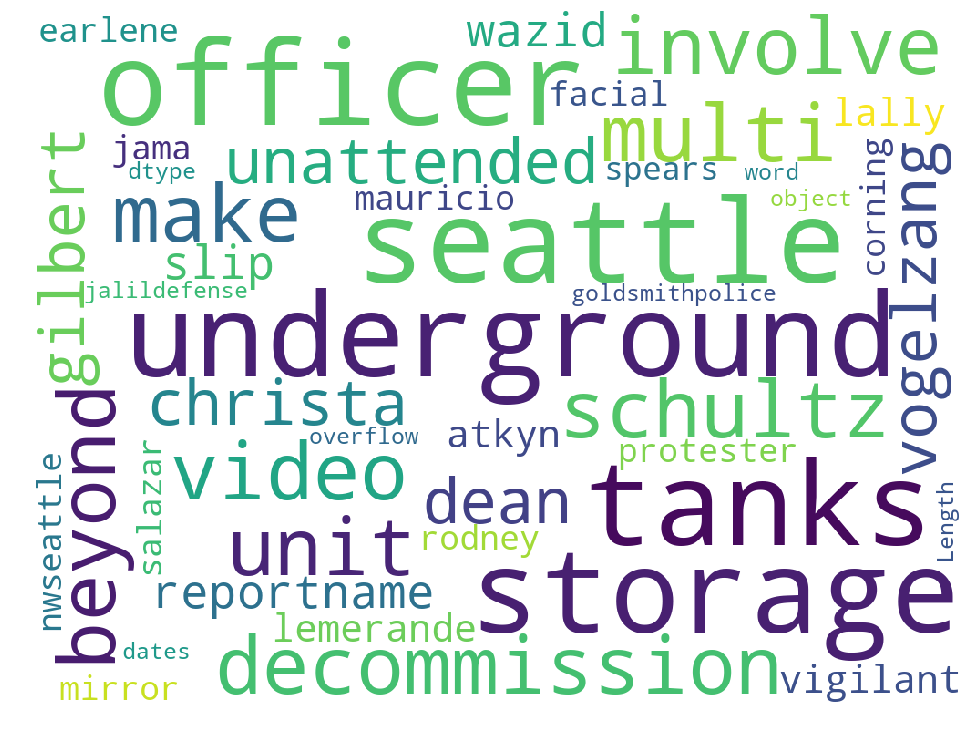

In [20]:
# specify words to filter out
FILTER = ['which', 'follow', 'between', 'each', 'send',
            'call', 'department', 'name', 'date', 'case',
            'provide', 'number', 'regard', 'information',
            'would', 'relate', 'incident', 'email',
            'public', 'include', 'datum', 'police', 'record']

# generate the word cloud
showcloud(wc_gen, FILTER=FILTER)

# Topics Over Time

This section consists of visualizations of the most salient topics over time. These topics were gathered through a combination of statistical analyses with design thinking processes, as outlined in the notebook "NLP on PRR". Check it out for some theoretical information on latent dirichlet allocation (LDA), and some process-based stuff related to how we named the topics.

In [21]:
# plot topics of interest across seattle
everything = filter_dfs(topics, 'ALL:')
line(everything)

In [22]:
# plot topics of interest across seattle
seattle_trends = filter_dfs(topics, 'SEA:')
line(seattle_trends)

In [23]:
# plot topics of interest across port orchard
por_trends = filter_dfs(topics, 'POR:')
line(por_trends)

In [24]:
# plot topics of interest across olympia
oly_trends = filter_dfs(topics, 'OLY:')
line(oly_trends)

## Now you try!

If you would like to search for your own topics (collections of words of interest) within the corpus, that's possible! Try out the following in the cell below:

0. **Figure out if you want to look at all the data**, or data for a particular jurisdiction. If you want to look at everything, move on to step 1. If you want to look at a particular locale, uncomment out the line at the top of the next cell, and replace the three letters there with the three-letter abbreviation for your city of interest (SEA, POR, or OLY).
1. **For each topic you want to model, create a sub-list**. A sub-list is everything between `[ ]`, and occurring within the outer brackets. Right now, there are three sub-lists, and they each have two keywords to search. **Be sure to have between 2-8 topics, or else the plot will not be generated correctly.**
2. **Add any number of terms to the list**. Each term should have `' '` around it, and should be separated by commas.
3. **Run the cell.** After a few seconds the program should produce a graph of your keywords. If you get an error, it is probably because the term is not in the dataset. Keep trying!

If you feel lost with the code, be sure to review Python syntax related to comments, lists, and strings.

If you are having trouble coming up with research questions, figuring out what percentage of requests for a given month are devoted to the topic above (or devoted to your topic of interest) could be a good start.

In [25]:
# TO LOOK AT ONLY A SUBSET OF THE DATA, UNCOMMENT THE LINE BELOW
#words_over_time = words_over_time[words_over_time.location == 'SEA']

user_topics = [
    
    # THESE ARE THE SUB-TOPIC LISTS
    ['request', 'information', ],
    ['hospital', 'surgeon', 'code'],
    ['stale', 'dated', 'check', ],
    ['starbucks', 'coffee', 'shop', 'pumpkin', 'spice', 'latte', ],

]

make_user_plots()

# Cosine Word Similarity

This *word similarity plot* is a visualization of all the words in the corpus of public records documents. Each word is represented as a vector in a 2D plane.

The tool looks at the nearest neighbors for each word in the dataset, evaluating whether or not a word is used in a similar context to another word. It is intended to be used as a catalyst for insight--a user might notice that many different media-related words are clustered together, and see a word they hadn't associated with the group. That, in turn, could lead them to searching records requests for mentions of that word and finding patterns where there was previously noise. 

For a theoretical explanation about representing words as vectors, and what that allows us to do, check out the NLP on PRR main analysis notebook.

**Mouse around and see what you can discover**! The *tooltip* tool should be selected by default. If you'd like to look closer, deselect the tooltip tool and select the *box zoom* tool.

In [26]:
scatter(coords)

# Analogy Generator

Like the word similarity tool, the *analogy generator* provides an associative understanding of noun phrases and words used within the corpus of public records. It provides a different way of looking at the relationships between words in a more playful fashion. Let's check some out!

In [27]:
# this cell displays a series of analogies
show_analogies()

['surveillance is to recordings as audio is to video.',
 'dashcam is to video as underground is to tanks.',
 'tank is to oil as request is to record.',
 'permit is to garage as parcel is to zoning.',
 'port is to orchard as olympia is to seattle.',
 'state is to washington as county is to thurston.',
 'A is to B as Y is to Z.']

In [28]:
# if you want to try out your own analogy, type it here...
word_analogy('water', 'ferry', 'bay')

'water is to billing as ferry is to bay.'

In [29]:
# and we can of course do the same with noun phrases/nouns
ent_analogy('WA', 'Olympia', 'Washington')

'WA is to 98501 as Olympia is to Washington.'

In [30]:
# if you want to try out your own analogy, type it here...
word_analogy('surveillance', 'audio', 'video')

'surveillance is to recordings as audio is to video.'

# Acknowledgements

Thank you to Leslie Denning for beta testing and suggestions during prototyping; Will Saunders for troubleshooting and sponsorship; and Carol Palmer, Bree Norlander, and Nic Weber for continued support and advising throughout the project.

And thank you, dear user, for being curious enough to play around. :)